In [8]:
import numpy as np
import time
# np.seterr(all='raise')
np.seterr(under='ignore', invalid='raise', divide='raise', over='raise')
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS
from scipy.special import zeta, polygamma, factorial
import matplotlib as mpl
from mpmath import zeta
from itertools import cycle
from scipy.special import kve
from functions import *
from xsec_expressions import *


mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

In [20]:
def make_params(mchi, mA, alphaD, eps, gchi = 2, gA = 3, no_Th_evolution = False, tdep = True):
    return {
        "mchi": mchi, "mA": mA,
        "alphaD": alphaD, "epsilon": eps,
        "sv_xxAA": sigma_xx_to_AA(alphaD, mchi, mA),
        "sv_xxee": sigmav_chichi_ee(eps, alphaD, mchi, mA),
        "gamma_Aee": gammaA_ee(eps, mA),
        "t_dep": tdep, "gchi": gchi, "gA": gA,
        "no_Th_evolution": no_Th_evolution
    }

def update_alphaD(params, new_alphaD):
    new_params = params.copy()
    new_params["alphaD"] = new_alphaD
    new_params["sv_xxAA"] = sigma_xx_to_AA(new_alphaD, params["mchi"], params["mA"])
    new_params["sv_xxee"] = sigmav_chichi_ee(params["epsilon"], new_alphaD, params["mchi"], params["mA"])
    return new_params

def update_alphaD_and_eps(params, new_alphaD, new_epsilon):
    new_params = params.copy()
    new_params["alphaD"] = new_alphaD
    new_params["epsilon"] = new_epsilon
    new_params["sv_xxAA"] = sigma_xx_to_AA(new_alphaD, params["mchi"], params["mA"])
    new_params["sv_xxee"] = sigmav_chichi_ee(new_epsilon, new_alphaD, params["mchi"], params["mA"])
    new_params["gamma_Aee"] = gammaA_ee(new_epsilon, params["mA"])
    return new_params


In [10]:
OMEGA_TARGET = 0.12

def omega_of_params(params, xs, ic):
    out = evolve(params, x_initial=xs[0], x_final=xs[-1], y0=ic, xs=xs, log_space=True, rtol=1e-5, atol=1e-10)
    sol = out["sol"]; x_arr = out["x_arr"]
    nchi, nA, Th = sol
    T  = params["mchi"] / x_arr
    Yx = Y(np.asarray(nchi), T)
    omega = get_relic_abundance(Yx[-1], params["mchi"])

    # freeze-out locator
    #diag = compute_diagnostics(x_arr, sol, params)
    #ixf = np.argmin(np.abs(diag["Gamma_chem_over_H"] - 1.0))
    #success = np.isfinite(omega) and (diag["Gamma_chem_over_H"][0] > 10)
    success = True

    return omega, {"success": success}# , "x_f": x_arr[ixf], "diag": diag}


def solve_alphaD_for_target(params, xs, ic, u_lo=-7.0, u_hi=-2.0, tol=0.05, maxit=40):
    def F(u):
        #p = dict(params); p["alphaD"] = 10.0**u
        #p = params.copy(); p["alphaD"] = 10.0**u
        #p = make_params(params)
        p = update_alphaD(params, 10.0**u)
        print(p)
        omega, meta = omega_of_params(p, xs, ic)
        print("alphaD = %.3e -> omega = %.3e (target %.3e)" % (p["alphaD"], omega, OMEGA_TARGET))
        return omega/OMEGA_TARGET - 1.0, meta

    f_lo, meta_lo = F(u_lo); f_hi, meta_hi = F(u_hi)
    if f_lo < 0: u_lo, u_hi, f_lo, f_hi = u_hi, u_lo, f_hi, f_lo # ensure f_lo > 0, f_hi < 0

    for _ in range(maxit):
        u_mid = 0.5*(u_lo + u_hi)
        f_mid, meta_mid = F(u_mid)
        if not meta_mid["success"]:
            u_hi = u_mid; f_hi = f_mid; continue
        if abs(f_mid) <= tol:
            return 10.0**u_mid, meta_mid
        if f_mid > 0:   # if omega too large then alphaD too small
            u_lo, f_lo = u_mid, f_mid
        else:
            u_hi, f_hi = u_mid, f_mid
    return 10.0**u_mid, meta_mid


def scan_grid(alpha_grid, eps_grid, params, xs, ic):
    Omega = np.full((len(alpha_grid), len(eps_grid)), np.nan)
    dom   = np.zeros_like(Omega, dtype=int)  # 0=bad, 1=AA, 2=SM
    for i, a in enumerate(alpha_grid):
        for j, e in enumerate(eps_grid):
            #p = dict(params); p["alphaD"]=a; p["epsilon"]=e
            p = update_alphaD_and_eps(params, a, e)

            omega, meta = omega_of_params(p, xs, ic=ic)
            #if not meta["success"]: continue
            Omega[i,j] = omega
            #d = meta["diag"]
            #aa = d["Gamma_xAA_over_H"][np.argmin(np.abs(d["x"]-meta["x_f"]))]
            #sm = d["Gamma_xSM_over_H"][np.argmin(np.abs(d["x"]-meta["x_f"]))]
            #dom[i,j] = 1 if aa>sm else 2
            print("alphaD=%.3e, eps=%.3e -> Omega=%.3e" % (a, e, omega))
    return Omega, dom

In [27]:
alpha = 1.2e-4
epsilon =  3e-6
mchi = 10 # 0.3
mA = 8 # 0.3*0.7
gchi = 4
gA = 3


params = make_params(mchi, mA, alpha, epsilon)
x_i, x_f = 1.0, 400.0
T_i = mchi / x_i

Th_i = 1e-2*T_i
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)
y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

# alphaD_sol, meta = solve_alphaD_for_target(params, xs, ic = y0, u_lo=-5.0, u_hi=-3.0, tol=0.01, maxit=30)

In [ ]:
# scan range, want to find alpha at which the density is epsilon-independent

# alpha, epsilon
out_scan = scan_grid(np.logspace(-4, -3, 4), np.logspace(-10, -7, 4), params, xs, y0)

alphaD=1.000e-04, eps=1.000e-10 -> Omega=1.898e+00
alphaD=1.000e-04, eps=1.000e-09 -> Omega=1.733e+00
alphaD=1.000e-04, eps=1.000e-08 -> Omega=1.397e+00
alphaD=1.000e-04, eps=1.000e-07 -> Omega=1.108e+00
alphaD=2.154e-04, eps=1.000e-10 -> Omega=4.354e-01
alphaD=2.154e-04, eps=1.000e-09 -> Omega=3.955e-01
alphaD=2.154e-04, eps=1.000e-08 -> Omega=3.179e-01
alphaD=2.154e-04, eps=1.000e-07 -> Omega=2.601e-01
alphaD=4.642e-04, eps=1.000e-10 -> Omega=9.939e-02
alphaD=4.642e-04, eps=1.000e-09 -> Omega=8.981e-02
alphaD=4.642e-04, eps=1.000e-08 -> Omega=7.204e-02
alphaD=4.642e-04, eps=1.000e-07 -> Omega=6.070e-02
alphaD=1.000e-03, eps=1.000e-10 -> Omega=2.259e-02
alphaD=1.000e-03, eps=1.000e-09 -> Omega=2.031e-02
alphaD=1.000e-03, eps=1.000e-08 -> Omega=1.626e-02
alphaD=1.000e-03, eps=1.000e-07 -> Omega=1.409e-02


In [24]:
params2 = make_params(mchi, mA, alpha, epsilon, tdep = True)
out_scan2 = scan_grid(np.logspace(-5, -3, 4), np.logspace(-8, -6, 4), params2, xs, y0)

alphaD=1.000e-05, eps=1.000e-08 -> Omega=1.653e+01
alphaD=1.000e-05, eps=4.642e-08 -> Omega=1.278e+01
alphaD=1.000e-05, eps=2.154e-07 -> Omega=1.253e+01
alphaD=1.000e-05, eps=1.000e-06 -> Omega=1.252e+01
alphaD=4.642e-05, eps=1.000e-08 -> Omega=8.880e-01
alphaD=4.642e-05, eps=4.642e-08 -> Omega=7.442e-01
alphaD=4.642e-05, eps=2.154e-07 -> Omega=7.358e-01
alphaD=4.642e-05, eps=1.000e-06 -> Omega=7.356e-01
alphaD=2.154e-04, eps=1.000e-08 -> Omega=4.650e-02
alphaD=2.154e-04, eps=4.642e-08 -> Omega=4.198e-02
alphaD=2.154e-04, eps=2.154e-07 -> Omega=4.166e-02
alphaD=2.154e-04, eps=1.000e-06 -> Omega=4.161e-02
alphaD=1.000e-03, eps=1.000e-08 -> Omega=2.391e-03
alphaD=1.000e-03, eps=4.642e-08 -> Omega=2.313e-03
alphaD=1.000e-03, eps=2.154e-07 -> Omega=2.301e-03
alphaD=1.000e-03, eps=1.000e-06 -> Omega=2.300e-03


In [ ]:
params3 = make_params(mchi, mA, alpha, epsilon, tdep = True)
x_i, x_f = 1.0, 400.0
T_i = mchi / x_i

Th_i = 1e-1*T_i
nchi_i = 1e-6
nA_i  = 1e-6
y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

out_scan3 = scan_grid(np.logspace(-5, -3, 4), np.logspace(-8, -6, 4), params2, xs, y0)

alphaD=1.000e-05, eps=1.000e-08 -> Omega=1.362e+01
alphaD=1.000e-05, eps=4.642e-08 -> Omega=1.277e+01
alphaD=1.000e-05, eps=2.154e-07 -> Omega=1.253e+01
alphaD=1.000e-05, eps=1.000e-06 -> Omega=1.253e+01
alphaD=4.642e-05, eps=1.000e-08 -> Omega=7.765e-01
alphaD=4.642e-05, eps=4.642e-08 -> Omega=7.438e-01
alphaD=4.642e-05, eps=2.154e-07 -> Omega=7.355e-01
alphaD=4.642e-05, eps=1.000e-06 -> Omega=7.351e-01
alphaD=2.154e-04, eps=1.000e-08 -> Omega=4.204e-02
alphaD=2.154e-04, eps=4.642e-08 -> Omega=4.199e-02
alphaD=2.154e-04, eps=2.154e-07 -> Omega=4.168e-02
alphaD=2.154e-04, eps=1.000e-06 -> Omega=4.162e-02
alphaD=1.000e-03, eps=1.000e-08 -> Omega=2.213e-03
alphaD=1.000e-03, eps=4.642e-08 -> Omega=2.313e-03
alphaD=1.000e-03, eps=2.154e-07 -> Omega=2.300e-03
alphaD=1.000e-03, eps=1.000e-06 -> Omega=2.301e-03


Text(0.5, 0, '$\\log_{10} \\alpha_D$')

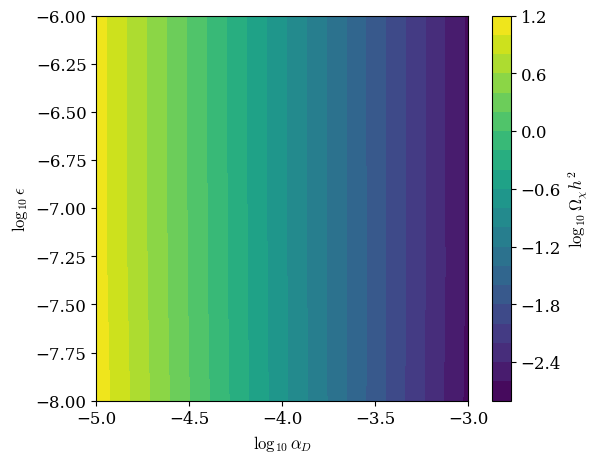

In [33]:
Omega, dom = out_scan3

epsilon = np.logspace(-8, -6, 4)
alphaD = np.logspace(-5, -3, 4)
fig, ax = plt.subplots(figsize=(6,5))

cs = ax.contourf(np.log10(np.array(alphaD)), np.log10(np.array(epsilon)), np.log10(Omega).T, levels=20, cmap='viridis')
cbar = fig.colorbar(cs)
cbar.set_label(r'$\log_{10} \Omega_\chi h^2$')
ax.set_ylabel(r'$\log_{10} \epsilon$')
ax.set_xlabel(r'$\log_{10} \alpha_D$')

In [ ]:
OMEGA_TARGET = 0.12

def extract_relic_curve_from_grid(alpha_grid, eps_grid, Omega, omega_target=OMEGA_TARGET):
    """
    Return a list of (alpha_arr, eps_arr) arrays describing the Omega = omega_target contour(s).
    alpha_grid: 1D array of alpha_D values (length N_alpha)
    eps_grid:   1D array of epsilon values (length N_epsilon)
    Omega:      2D array with shape (N_alpha, N_epsilon) giving Omega(alpha, eps)
    """
    Z = np.array(Omega).T

    fig, ax = plt.subplots(figsize =  (12, 4))

    # linear interpolation,  handled internally
    # treats parameter space as continuous 2D surface
    CS = ax.contour(alpha_grid, eps_grid, Z, levels=[omega_target])

    curves = []
    if not CS.allsegs or len(CS.allsegs[0]) == 0:
        plt.close(fig)
        return curves

    for seg in CS.allsegs[0]:
        alpha_curve = seg[:, 0]
        eps_curve   = seg[:, 1]
        curves.append((alpha_curve, eps_curve))

    plt.close(fig)
    return curves


In [51]:
alpha = 1.2e-4
epsilon =  3e-6
mchi = 10 # 0.3
mA = 8 # 0.3*0.7
gchi = 4
gA = 3


params = make_params(mchi, mA, alpha, epsilon, tdep = True)
x_i, x_f = 1.0, 400.0
T_i = mchi / x_i

Th_i = T_i
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)
y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

In [ ]:
alpha_grid = np.array([0.9e-4, 1.2e-4, 1.5e-4])
eps_grid   = np.logspace(-10, -7, 4)
Omega, dom = scan_grid(alpha_grid, eps_grid, params, xs, y0)

alphaD=9.000e-05, eps=1.000e-10 -> Omega=3.246e-01
alphaD=9.000e-05, eps=1.000e-09 -> Omega=3.002e-01
alphaD=9.000e-05, eps=1.000e-08 -> Omega=2.494e-01
alphaD=9.000e-05, eps=1.000e-07 -> Omega=2.145e-01
alphaD=1.200e-04, eps=1.000e-10 -> Omega=1.872e-01
alphaD=1.200e-04, eps=1.000e-09 -> Omega=1.727e-01
alphaD=1.200e-04, eps=1.000e-08 -> Omega=1.435e-01
alphaD=1.200e-04, eps=1.000e-07 -> Omega=1.250e-01
alphaD=1.500e-04, eps=1.000e-10 -> Omega=1.221e-01
alphaD=1.500e-04, eps=1.000e-09 -> Omega=1.124e-01
alphaD=1.500e-04, eps=1.000e-08 -> Omega=9.343e-02
alphaD=1.500e-04, eps=1.000e-07 -> Omega=8.235e-02


In [63]:
alpha_grid2 = np.array([0.1e-4, 0.005e-4])
eps_grid2   = np.logspace(-10, -7, 4)
params2 = params.copy()
params2["mA"] = 5.0
Omega2, dom2 = scan_grid(alpha_grid2, eps_grid2, params2, xs, y0)

alphaD=1.000e-05, eps=1.000e-10 -> Omega=8.260e+00
alphaD=1.000e-05, eps=1.000e-09 -> Omega=8.007e+00
alphaD=1.000e-05, eps=1.000e-08 -> Omega=7.424e+00
alphaD=1.000e-05, eps=1.000e-07 -> Omega=7.260e+00
alphaD=5.000e-07, eps=1.000e-10 -> Omega=2.110e+03
alphaD=5.000e-07, eps=1.000e-09 -> Omega=2.069e+03
alphaD=5.000e-07, eps=1.000e-08 -> Omega=1.938e+03
alphaD=5.000e-07, eps=1.000e-07 -> Omega=1.597e+03


Segment 0: 4 points


(-5.0, -3.0)

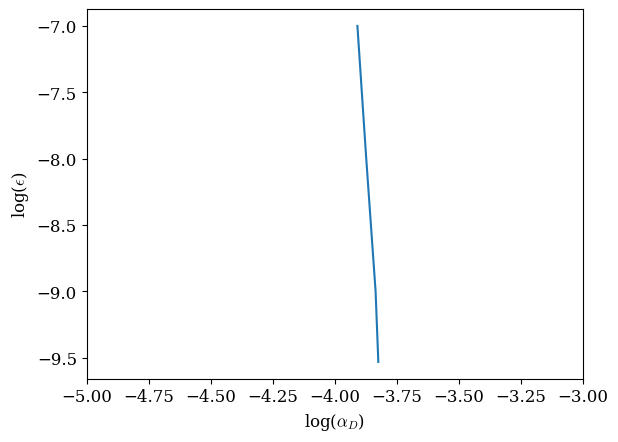

In [ ]:
# params3 = params2.copy()
# params3["mA"] = 2
# Omega2, dom2 = scan_grid(alpha_grid, eps_grid, params3, xs, y0)

curves = extract_relic_curve_from_grid(alpha_grid, eps_grid, Omega)
#curves2 = extract_relic_curve_from_grid(alpha_grid, eps_grid, Omega2)

for k, (alpha_c, eps_c) in enumerate(curves):
    print(f"Segment {k}: {len(alpha_c)} points")
    log_alpha_c = np.log10(alpha_c)
    log_epsilon = np.log10(eps_c)
    plt.plot(log_alpha_c, log_epsilon, label=f'Segment {k}')

# for k, (alpha_c, eps_c) in enumerate(curves2):
#     print(f"Segment {k} (mA=2): {len(alpha_c)} points")
#     log_alpha_c = np.log10(alpha_c)
#     log_epsilon = np.log10(eps_c)
#     plt.plot(log_alpha_c, log_epsilon, linestyle='--', label=f'Segment {k} (mA=2)')


plt.xlabel(r'log($\alpha_D$)')
plt.ylabel(r'log($\epsilon$)')

plt.xlim(-5, -3)

Segment 0: 0 points


Text(0, 0.5, 'log($\\epsilon$)')

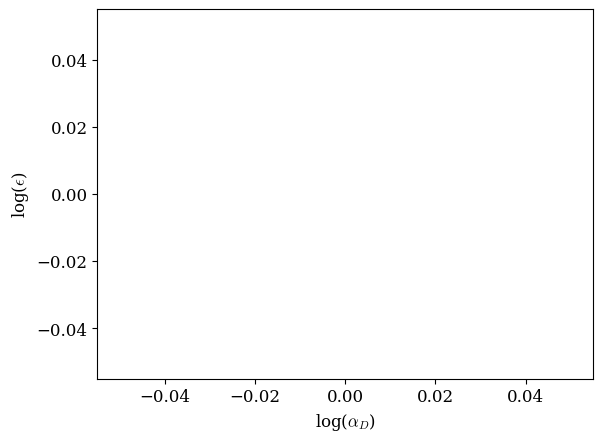

In [59]:
# params3 = params2.copy()
# params3["mA"] = 2
# Omega2, dom2 = scan_grid(alpha_grid, eps_grid, params3, xs, y0)

curves = extract_relic_curve_from_grid(alpha_grid, eps_grid, Omega)
#curves2 = extract_relic_curve_from_grid(alpha_grid, eps_grid, Omega2)

for k, (alpha_c, eps_c) in enumerate(curves):
    print(f"Segment {k}: {len(alpha_c)} points")
    log_alpha_c = np.log10(alpha_c)
    log_epsilon = np.log10(eps_c)
    plt.plot(log_alpha_c, log_epsilon, label=f'Segment {k}')

# for k, (alpha_c, eps_c) in enumerate(curves2):
#     print(f"Segment {k} (mA=2): {len(alpha_c)} points")
#     log_alpha_c = np.log10(alpha_c)
#     log_epsilon = np.log10(eps_c)
#     plt.plot(log_alpha_c, log_epsilon, linestyle='--', label=f'Segment {k} (mA=2)')


plt.xlabel(r'log($\alpha_D$)')
plt.ylabel(r'log($\epsilon$)')
